# Basic CV2 blur detections: 
This notebook is a exploratory using cv2.Laplacian. It has shown some success  with incredibly blurry data, hopefully, we can then utlize this model to detect bluriness in the dataset.
**Reference: 
    - Some of the code here is based on the [Blur Detection with OpenCV](https://pyimagesearch.com/2015/09/07/blur-detection-with-opencv/) article

In [1]:
import logging
import json
import cv2
import pandas as pd
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
#Check and yield image file paths from a list of directory paths.
def image_file_check(paths):
    img_extensions = ['.jpg', '.png', '.jpeg', '.JPG', '.PNG', '.JPEG']
    for path in paths:
        if os.path.isfile(path):
            if any(path.endswith(ext) for ext in img_extensions):
                yield path
        elif os.path.isdir(path):
            for root, _, files in os.walk(path):
                for file in files:
                    if any(file.endswith(ext) for ext in img_extensions):
                        yield os.path.join(root, file)

In [3]:
# Resize an image to have approximately the expected number of pixels.
def resize_image(image: np.array, expected_pixels: float = 2E6):
    ratio = np.sqrt(expected_pixels / (image.shape[0] * image.shape[1]))
    return cv2.resize(image, (0, 0), fx=ratio, fy=ratio)

# Estimate the bluriness of an image using the variance of the Laplacian.
def estimate_blur(image: np.array, threshold: int = 100):
    if image.ndim == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    blur_map = cv2.Laplacian(image, cv2.CV_64F)
    score = np.var(blur_map)
    return blur_map, score, bool(score < threshold)


In [4]:
#    Process images in a directory to evaluate their bluriness.

def process_images(image_dir, threshold=100.0, fix_size=True, display=False):
    results = []

    # Iterate over each image path found by the image_file_check function
    for image_path in image_file_check([image_dir]):
        # Read the image from the file
        image = cv2.imread(str(image_path))
        if image is None:
            logging.warning(f'warning! failed to read image from {image_path}; skipping!')
            continue

        logging.info(f'processing {image_path}')

        # Optionally resize the image for consistent scoring
        if fix_size:
            image = resize_image(image)
        else:
            logging.warning('not normalizing image size for consistent scoring!')

        # Estimate the bluriness of the image
        blur_map, score, blurry = estimate_blur(image, threshold=threshold)

        logging.info(f'image_path: {image_path} score: {score} blurry: {blurry}')
        
        # Append the results to the list, using os.path.basename to get the filename
        results.append({'input_path': os.path.basename(image_path), 'score': score, 'blurry': blurry})
    
    # Convert the results list to a pandas DataFrame and return
    return pd.DataFrame(results)

In [5]:
# Set parameters
current_wd = os.getcwd()
clear_image_dir = os.path.join(current_wd, 'data/clear')
threshold = 90.0

# Run processing
df = process_images(clear_image_dir, threshold, fix_size=True, display=False)

# Display the DataFrame
df.head()


,input_path,score,blurry
0,00162.png,12.749346,True
1,00212.png,7.450912,True
2,00222.png,14.607432,True
3,00312.png,14.973640,True
4,00332.png,17.082595,True


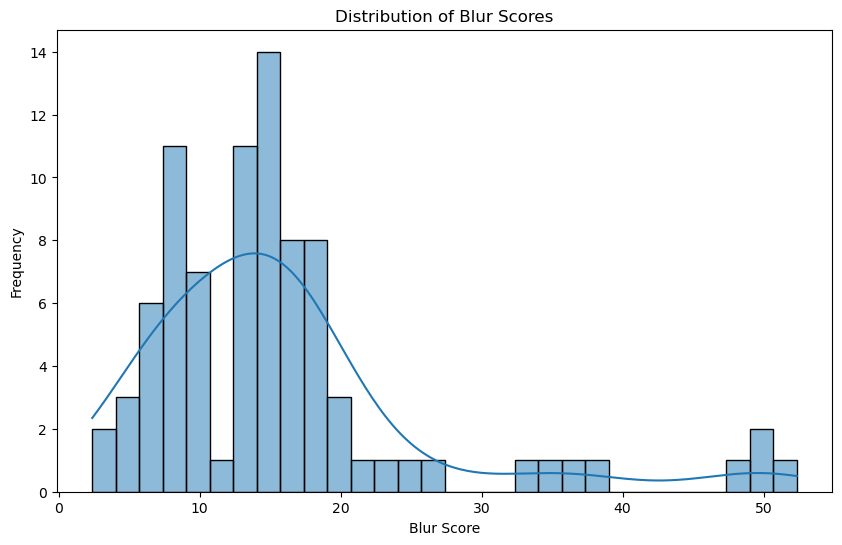

In [6]:
# Create a distribution plot for the 'score' column
plt.figure(figsize=(10, 6))
sns.histplot(df['score'], kde=True, bins=30)
plt.title('Distribution of Blur Scores')
plt.xlabel('Blur Score')
plt.ylabel('Frequency')
plt.show()


In [7]:
current_wd = os.getcwd()
blur_image_dir = os.path.join(current_wd, 'data/blurry')
threshold = 90.0
fix_size = True
display = False


# Run processing
blur_df = process_images(blur_image_dir, threshold, fix_size, display)

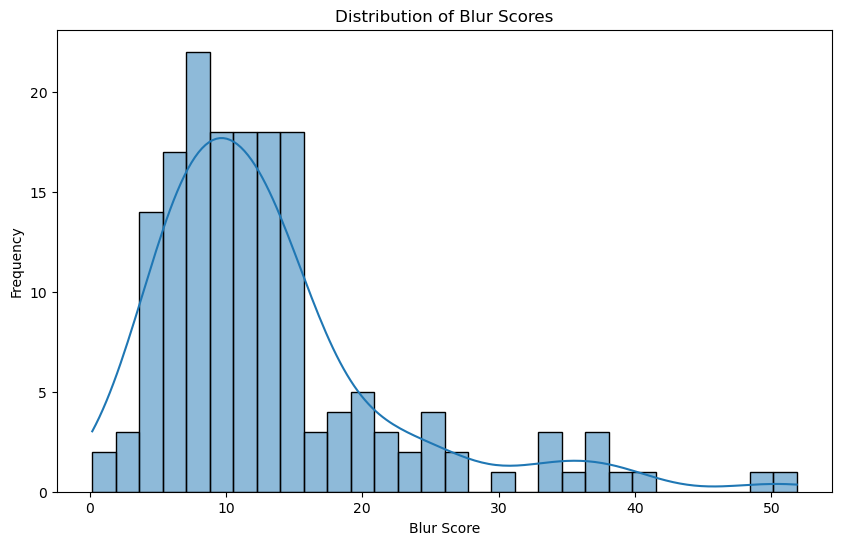

In [8]:
# Create a distribution plot for the 'score' column
plt.figure(figsize=(10, 6))
sns.histplot(blur_df['score'], kde=True, bins=30)
plt.title('Distribution of Blur Scores')
plt.xlabel('Blur Score')
plt.ylabel('Frequency')
plt.show()

In [9]:
blur_df[blur_df['score']>=40] 

,input_path,score,blurry
76,01482.png,48.991316,True
85,01622.png,51.861912,True
87,01652.png,40.074621,True


From the documentation, the high score in this case should represent a clear image. From the article, it is mentioned "The large focus measure score indicates that the image is non-blurry." After inspecting the model's performance, the score and the articles, I realize that it might be difficult to apply this model to Sesame Street data because the data doesn't share the same high resolutions as the data used in the article. 
This makes me realize I need to create a CNN model with a head of CV2 architecture to train specifically for sesame street. 